<a href="https://colab.research.google.com/github/farahshahhoud/Machine_Learning/blob/master/%D0%94%D0%97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Цель работы:
решение сложной проблемы машинного обучения. Наша цель - построить модель машинного обучения классификации набора данных.

#набор данных
Наш набор данных о титаническом путешествии. Он содержит множество характеристик пассажиров на корабле и целевую функцию «Выживание». Атрибут Survival имеет значение 0 или 1, которое определяет, выжил ли этот пассажир на тонущем корабле или нет. Набор данных также имеет отдельный файл, содержащий тестовые значения. Но тестовые значения не имеют геометрию Survival. Таким образом, после построения нашей модели мы можем предсказать значения этой функции для тестовых данных (это на самом деле контекст на веб-сайте kaggle, и мы можем отправить данные туда, чтобы увидеть нашу оценку).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Dict, Tuple

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
%matplotlib inline 
sns.set(style="ticks")
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def draw_roc_curve(y_true, y_score, pos_label=1, average='micro'):
    fpr, tpr, thresholds = roc_curve(y_true, y_score, 
                                     pos_label=pos_label)
    roc_auc_value = roc_auc_score(y_true, y_score, average=average)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_value)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [3]:
data = pd.read_csv('/content/drive/My Drive/titanic/train.csv')
test = pd.read_csv('/content/drive/My Drive/titanic/test.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
total_count = data.shape[0]
print('Всего строк: {}'.format(total_count))

Всего строк: 891


In [6]:
data.shape

(891, 12)

In [7]:
test.shape

(418, 11)

In [8]:
# Список колонок
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [9]:
test.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [10]:
data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [11]:
test.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

#Aнализ и заполнение пропусков в данных

##Обработка пропусков в числовых данных

In [12]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [13]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [14]:
# Выберем числовые колонки с пропущенными значениями
# Цикл по колонкам датасета
num_cols = []
for col in data.columns:
    # Количество пустых значений 
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='float64' or dt=='int64'):
        num_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка Age. Тип данных float64. Количество пустых значений 177, 19.87%.


In [15]:
# Выберем числовые колонки с пропущенными значениями
# Цикл по колонкам датасета
num_cols = []
for col in test.columns:
    # Количество пустых значений 
    temp_null_count = test[test[col].isnull()].shape[0]
    dt = str(test[col].dtype)
    if temp_null_count>0 and (dt=='float64' or dt=='int64'):
        num_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка Age. Тип данных float64. Количество пустых значений 86, 9.65%.
Колонка Fare. Тип данных float64. Количество пустых значений 1, 0.11%.


In [0]:
# Фильтр по колонкам с пропущенными значениями
data_num = data['Age']
test_num= test['Age']
test_fare=test['Fare']

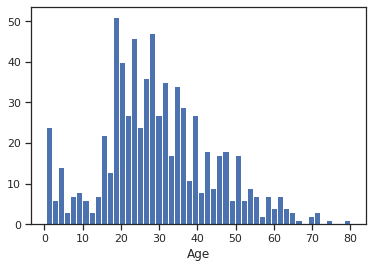

In [17]:
# Гистограмма по признакам
plt.hist(data_num, 50)
plt.xlabel('Age')
plt.show()

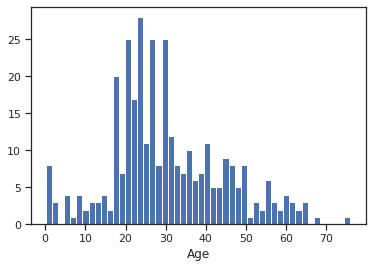

In [18]:
plt.hist(test_num, 50)
plt.xlabel('Age')
plt.show()

лучший способ уместить недостающие данные в Возрасте и Тарифе - заполнить их медианным возрастным числом, так как невозможно заполнить их 0.

In [0]:
data["Age"].fillna(data.groupby("Pclass")["Age"].transform("median"), inplace=True)
test["Age"].fillna(test.groupby("Pclass")["Age"].transform("median"), inplace=True)

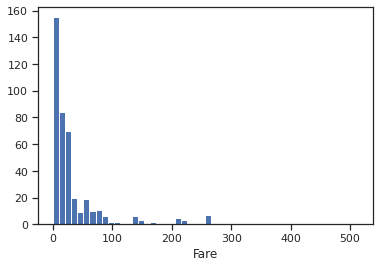

In [20]:
plt.hist(test_fare, 50)
plt.xlabel('Fare')
plt.show()

In [0]:
test["Fare"].fillna(test.groupby("Pclass")["Fare"].transform("median"), inplace=True)

In [22]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [23]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64

##Обработка пропусков в категориальных данных

In [24]:
# Выберем категориальные колонки с пропущенными значениями
# Цикл по колонкам датасета
cat_cols = []
for col in data.columns:
    # Количество пустых значений 
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='object'):
        cat_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка Cabin. Тип данных object. Количество пустых значений 687, 77.1%.
Колонка Embarked. Тип данных object. Количество пустых значений 2, 0.22%.


In [25]:
cat_colstest = []
for col in test.columns:
    # Количество пустых значений 
    temp_null_count = test[test[col].isnull()].shape[0]
    dt = str(test[col].dtype)
    if temp_null_count>0 and (dt=='object'):
        cat_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка Cabin. Тип данных object. Количество пустых значений 327, 36.7%.


In [26]:
data_col=data[cat_cols]
data_col.head()

,Cabin,Embarked,Cabin
0,NaN,S,NaN
1,C85,C,C85
2,NaN,S,NaN
3,C123,S,C123
4,NaN,S,NaN


In [0]:
data_num_Embarked = data_col[['Embarked']]
data_num_Cabin = data_col[['Cabin']]
test_num_Cabin = test[['Cabin']]

In [28]:
data['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [29]:
data['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [30]:
data['Cabin'].count()

204

In [31]:
print(data[data['Cabin'].str.startswith('A')==True].Age.count())
print(data[data['Cabin'].str.startswith('B')==True].Age.count())
print(data[data['Cabin'].str.startswith('C')==True].Age.count())
print(data[data['Cabin'].str.startswith('D')==True].Age.count())
print(data[data['Cabin'].str.startswith('E')==True].Age.count())
print(data[data['Cabin'].str.startswith('F')==True].Age.count())

15
47
59
33
32
13


Мы запишем признак Embarked, которые отсутствуют, с наиболее частым значением в наборе данных.

In [0]:
imp_num = SimpleImputer(strategy='most_frequent')
imp_num_fit = imp_num.fit_transform(data_num_Embarked)

In [0]:
data.Embarked=imp_num_fit

In [34]:
data.Cabin.value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
F33            3
D              3
              ..
E50            1
B3             1
B30            1
A10            1
C103           1
Name: Cabin, Length: 147, dtype: int64

Так как название салона связано с классом пассажира. Мы будем заполнять пустые значения самыми частыми классами для каждого класса отдельно. Вот почему мы сначала сгруппируемся по классу Pclass, а затем - по наиболее частым.

In [0]:
data["Cabin"].fillna(data.groupby("Pclass")["Cabin"].transform(lambda x:x.value_counts().index[0]), inplace=True)
test["Cabin"].fillna(test.groupby("Pclass")["Cabin"].transform(lambda x:x.value_counts().index[0]), inplace=True)

Убедиться, что у нас нет пропущенных значений

In [36]:
data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [37]:
test.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

#Построение графиков

In [0]:
def bar_chart(feature):
    survived = data[data['Survived']==1][feature].value_counts()
    dead = data[data['Survived']==0][feature].value_counts()
    df = pd.DataFrame([survived,dead])
    df.index = ['Survived','Dead']
    df.plot(kind='bar',stacked=True, figsize=(10,5))

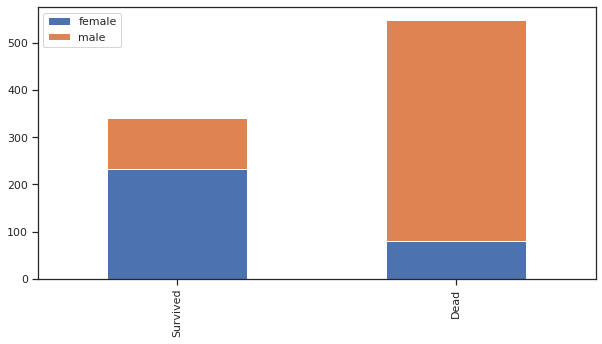

In [39]:
bar_chart('Sex')

Диаграмма подтверждает, что женщины выжили чаще, чем мужчины

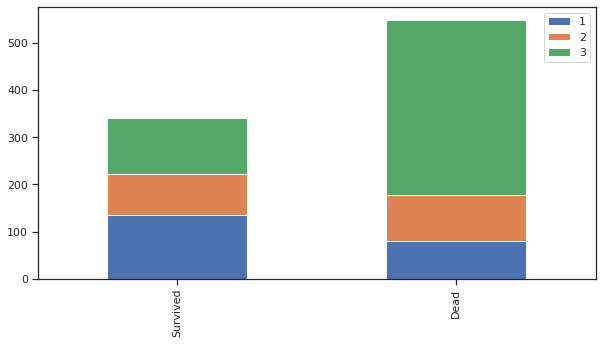

In [40]:
bar_chart('Pclass')

Диаграмма подтверждает, что 1-й класс выжил чаще других.  
Диаграмма подтверждает, что 3-й класс скорее мертв, чем другие.

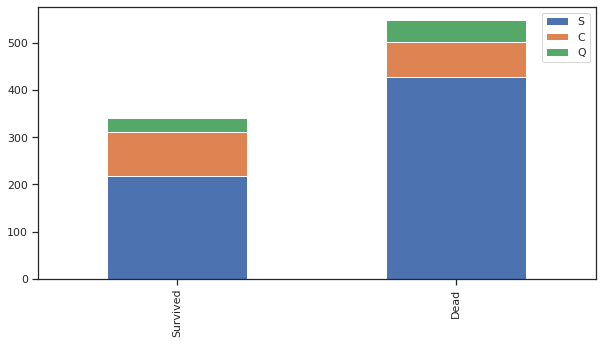

In [41]:
bar_chart('Embarked')

Диаграмма подтверждает, что человек, находящийся на борту C, несколько более вероятно выжил.   
Диаграмма подтверждает, что человек, находящийся на борту Q, скорее всего мертв.   
Диаграмма подтверждает, что человек, находящийся на борту S, скорее всего мертв.

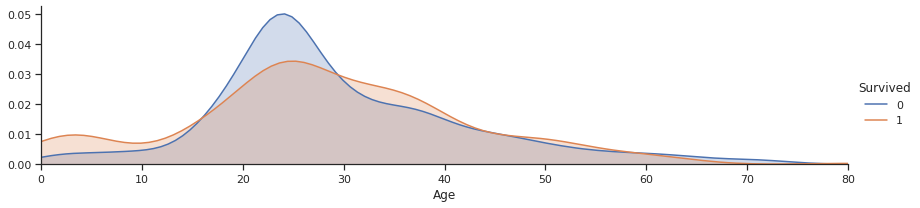

In [42]:
facet = sns.FacetGrid(data, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, data['Age'].max()))
facet.add_legend()
 
plt.show()

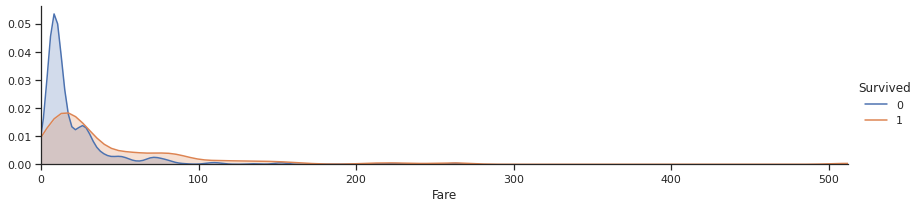

In [43]:
facet = sns.FacetGrid(data, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Fare',shade= True)
facet.set(xlim=(0, data['Fare'].max()))
facet.add_legend()
 
plt.show()

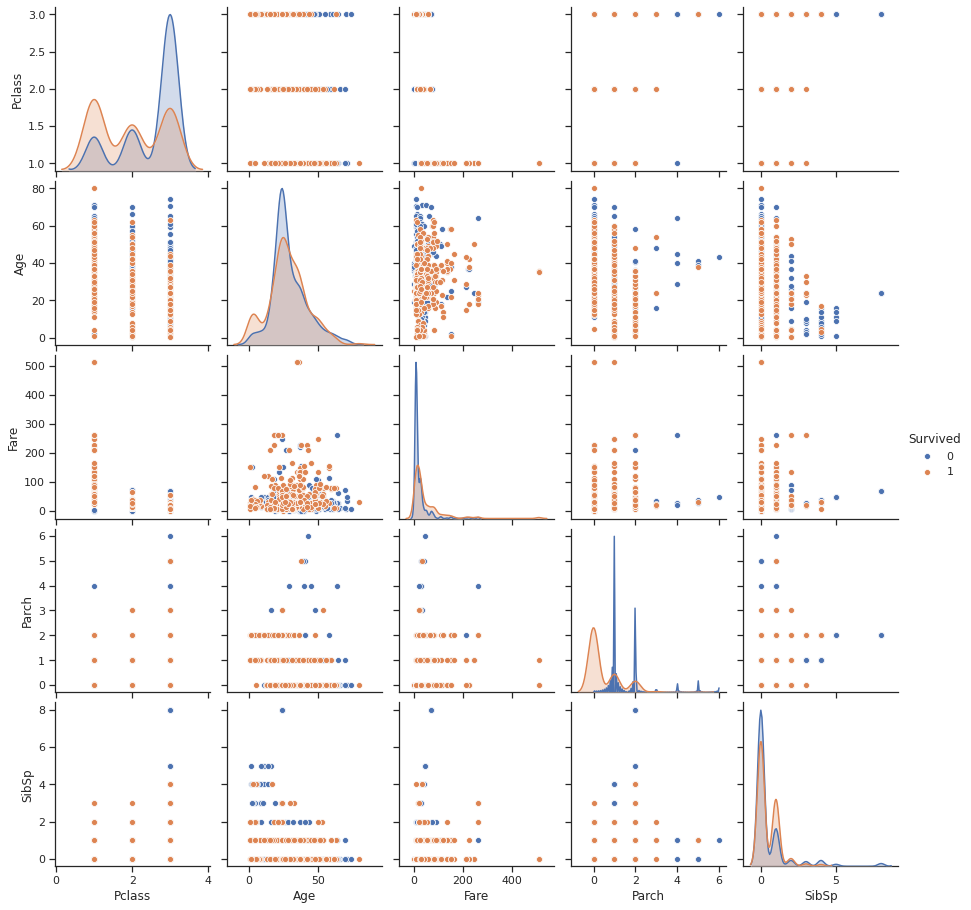

In [44]:
sns.pairplot(data[['Pclass','Age','Fare','Parch','SibSp','Survived']],hue="Survived",diag_kind='kde',kind='scatter')

Имя и номер билета не имеют ничего общего с выживанием человека. Вот почему мы можем отбросить эти столбцы, не влияя на результат. Но прежде чем мы это сделаем, мы сможем увидеть все специальные детали, которые могут содержаться в признаке «Имя».

In [0]:
train_test_data = [data, test] # combining train and test dataset

for dataset in train_test_data:
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [46]:
data['Title'].value_counts()


Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Mlle          2
Col           2
Ms            1
Countess      1
Lady          1
Capt          1
Sir           1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64

In [47]:
test['Title'].value_counts()


Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Dr          1
Ms          1
Dona        1
Name: Title, dtype: int64

Поскольку слова «Мистер», «Мисс» и «Миссис» отражают какую-то социальную ценность высокого класса и присутствуют как в тесте, так и в данных, мы добавим столбец, значение которого соответствует этим словам, присутствующим в Имя столбца. Имена, которые не содержат ни одного из этих слов, будут иметь значение 3.

In [0]:
title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, 
                 "Master": 3, "Dr": 3, "Rev": 3, "Col": 3, "Major": 3, "Mlle": 3,"Countess": 3,
                 "Ms": 3, "Lady": 3, "Jonkheer": 3, "Don": 3, "Dona" : 3, "Mme": 3,"Capt": 3,"Sir": 3 }
for dataset in train_test_data:
    dataset['Title'] = dataset['Title'].map(title_mapping)

# Кодирование категориальных признаков

Мы будем использовать простую кодировку для наших переменных объекта.

In [0]:
LE=LabelEncoder()

In [0]:
data_Sex=LE.fit_transform(data['Sex'])
data['Sex']=data_Sex

In [0]:
data_cabin=LE.fit_transform(data['Cabin'])
data['Cabin']=data_cabin

In [0]:
embarked_mapping = {"S": 0, "C": 1, "Q": 2}
for dataset in [data,test]:
    dataset['Embarked'] = dataset['Embarked'].map(embarked_mapping)

In [0]:
test_Sex=LE.fit_transform(test['Sex'])
test['Sex']=test_Sex

In [0]:
test_cabin=LE.fit_transform(test['Cabin'])
test['Cabin']=test_cabin

In [0]:
test_fare=LE.fit_transform(test['Fare'])
test['Fare']=test_fare

##Удаление столбцов имени и номера билета.

In [56]:
data=data.drop(['Name','Ticket'], axis=1)
data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,1,0,3,1,22.0,1,0,7.2500,145,0,0
1,2,1,1,0,38.0,1,0,71.2833,81,1,2
2,3,1,3,0,26.0,0,0,7.9250,145,0,1
3,4,1,1,0,35.0,1,0,53.1000,55,0,2
4,5,0,3,1,35.0,0,0,8.0500,145,0,0


In [57]:
test=test.drop(['Name','Ticket'], axis=1)
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,892,3,1,34.5,0,0,24,70,2,0
1,893,3,0,47.0,1,0,5,70,0,2
2,894,2,1,62.0,0,0,41,74,2,0
3,895,3,1,27.0,0,0,34,70,0,0
4,896,3,0,22.0,1,1,46,70,0,2


#Масштабирование данных

In [0]:
scale_cols=['Pclass', 'Sex', 'Title','Fare', 'Cabin','Parch','SibSp','Age']

In [0]:
sc1 = MinMaxScaler()
sc1_data = sc1.fit_transform(data[scale_cols])

In [0]:
for i in range(len(scale_cols)):
    col = scale_cols[i]
    new_col_name = col + '_scaled'
    data[new_col_name] = sc1_data[:,i]

In [100]:
data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Pclass_scaled,Sex_scaled,Title_scaled,Fare_scaled,Cabin_scaled,Parch_scaled,SibSp_scaled,Age_scaled
0,1,0,3,1,22.0,1,0,7.2500,145,0,0,1.0,1.0,0.000000,0.014151,0.993151,0.0,0.125,0.271174
1,2,1,1,0,38.0,1,0,71.2833,81,1,2,0.0,0.0,0.666667,0.139136,0.554795,0.0,0.125,0.472229
2,3,1,3,0,26.0,0,0,7.9250,145,0,1,1.0,0.0,0.333333,0.015469,0.993151,0.0,0.000,0.321438
3,4,1,1,0,35.0,1,0,53.1000,55,0,2,0.0,0.0,0.666667,0.103644,0.376712,0.0,0.125,0.434531
4,5,0,3,1,35.0,0,0,8.0500,145,0,0,1.0,1.0,0.000000,0.015713,0.993151,0.0,0.000,0.434531


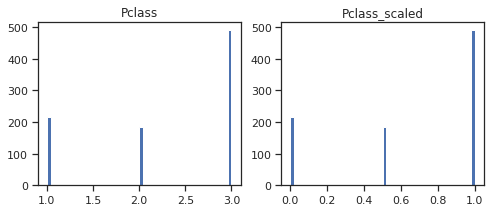

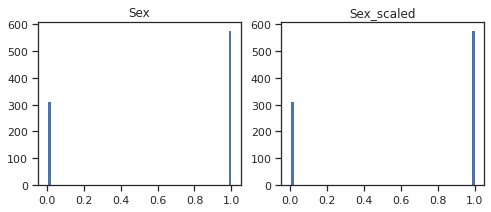

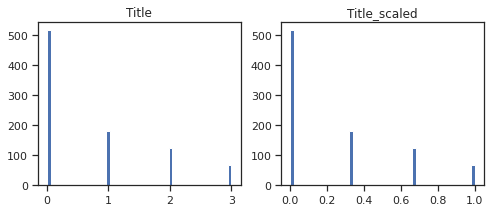

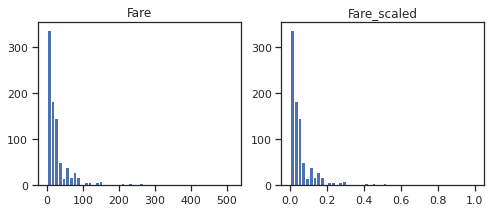

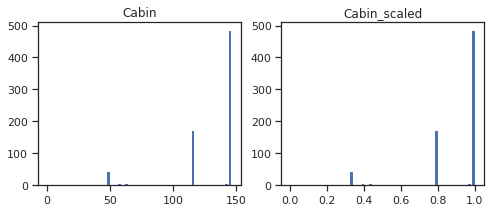

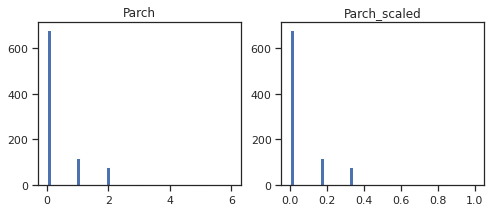

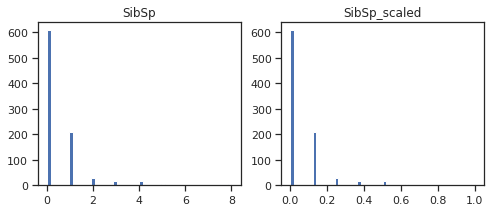

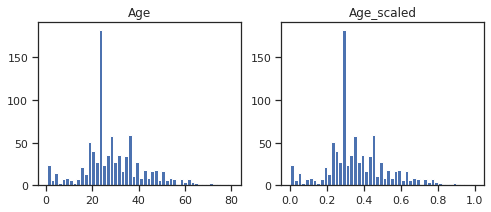

In [101]:
for col in scale_cols:
    col_scaled = col + '_scaled'

    fig, ax = plt.subplots(1, 2, figsize=(8,3))
    ax[0].hist(data[col], 50)
    ax[1].hist(data[col_scaled], 50)
    ax[0].title.set_text(col)
    ax[1].title.set_text(col_scaled)
    plt.show()

#Проведение корреляционного анализа данных.

In [0]:
corr_cols_1 = scale_cols + ['Survived']

In [0]:
scale_cols_postfix = [x+'_scaled' for x in scale_cols]
corr_cols_2 = scale_cols_postfix + ['Survived']

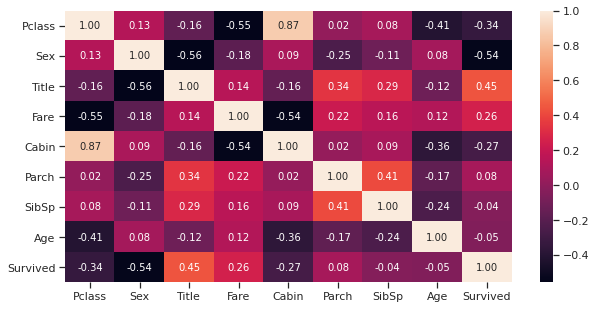

In [104]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data[corr_cols_1].corr(), annot=True, fmt='.2f')

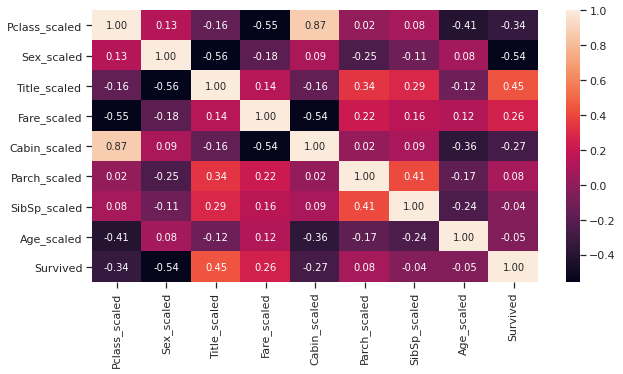

In [105]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data[corr_cols_2].corr(), annot=True, fmt='.2f')

Итак, мы видим, что корреляционные матрицы для исходных и масштабированных данных совпадают и идентификатор пассажира не должен быть включен в нашу модель, потому что он не имеет ничего общего с переменной Survival.    
Пол и заголовок (столбец, который мы добавили для некоторых признаков столбца «Имя») в наибольшей степени связаны с ним, а также Cabin, Pclass и Fare хорошо связаны с ним (поскольку он определяет класс пассажира).  
SibSp и Parch и возраст не очень связаны. Мы также можем пренебречь этими столбцами.

#Выбор метрик для последующей оценки качества моделей

Мы будем использовать метрику для точности, f1_score, отзыва и roc_auc. И мы увидим кривую roc_auc и значения матрицы путаницы.

In [0]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.5, a-0.05, str(round(b,3)), color='white')
        plt.show()    

#Выбор признаков, подходящих для построения моделей.

Как мы уже говорили, мы будем использовать Sex, Title, Pclass, Cabin и Fare за модель. Все остальные признаки мало связаны с колонкой Survived.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(data[['Pclass', 'Sex', 'Title',
       'Fare', 'Cabin']], data['Survived'], test_size=0.2, random_state=1)

In [69]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 5), (179, 5), (712,), (179,))

In [0]:
def class_proportions(array: np.ndarray) -> Dict[int, Tuple[int, float]]:
    """
    Вычисляет пропорции классов
    array - массив, содержащий метки классов
    """
    # Получение меток классов и количества меток каждого класса 
    labels, counts = np.unique(array, return_counts=True)
    # Превращаем количество меток в процент их встречаемости
    # делим количество меток каждого класса на общее количество меток
    counts_perc = counts/array.size
    # Теперь sum(counts_perc)==1.0
    # Создаем результирующий словарь,
    # ключом словаря явлется метка класса, 
    # а значением словаря процент встречаемости метки
    res = dict()
    for label, count2 in zip(labels, zip(counts, counts_perc)):
        res[label] = count2
    return res

def print_class_proportions(array: np.ndarray):
    """
    Вывод пропорций классов
    """
    proportions = class_proportions(array)
    if len(proportions)>0:
        print('Метка \t Количество \t Процент встречаемости')
    for i in proportions:
        val, val_perc = proportions[i]
        val_perc_100 = round(val_perc * 100, 2)
        print('{} \t {} \t \t {}%'.format(i, val, val_perc_100))

In [71]:
print_class_proportions(data.Survived)

Метка 	 Количество 	 Процент встречаемости
0 	 549 	 	 61.62%
1 	 342 	 	 38.38%


#Выбор моделей для решения задачи

Мы выберем многие модели для классификации, а затем сравним их производительность в зависимости от метрики. Поэтому мы будем использовать K-Neighbours Classifier с пятью соседями, классификатор дерева решений, классификатор случайных лесов, классификатор повышения градиента, классификатор мешков, классификатор дополнительных деревьев, классификатор повышения Ada.

In [0]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
clas_models = {'KNN_5':KNeighborsClassifier(n_neighbors=5),
               'Tree':DecisionTreeClassifier(),
               'RF':RandomForestClassifier(),
               'GB':GradientBoostingClassifier(),
               'Bag':BaggingClassifier(),
               'ExTree':ExtraTreesClassifier(),
               'Adab':AdaBoostClassifier()}

In [0]:
# Сохранение метрик
clasMetricLogger = MetricLogger()

In [0]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))

In [0]:
def clas_train_model(model_name, model, clasMetricLogger):
    model.fit(X_train, y_train)
    Y_pred = model.predict(X_test)
       

    precision = precision_score(y_test.values, Y_pred)
    recall = recall_score(y_test.values, Y_pred)
    f1 = f1_score(y_test.values, Y_pred)
    roc_auc = roc_auc_score(y_test.values, Y_pred)
    
    clasMetricLogger.add('precision', model_name, precision)
    clasMetricLogger.add('recall', model_name, recall)
    clasMetricLogger.add('f1', model_name, f1)
    clasMetricLogger.add('roc_auc', model_name, roc_auc)

    print('*****************************************************')
    print(model)
    print('*****************************************************')

    print_accuracy_score_for_classes(y_test, Y_pred)
    print('*****************************************************')


    
    draw_roc_curve(y_test.values, Y_pred)
    
    plot_confusion_matrix(model,X_test, y_test.values, 
                      display_labels=['0','1'], 
                      cmap=plt.cm.Blues, normalize='true')
    plt.show()

*****************************************************
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
*****************************************************
Метка 	 Accuracy
0 	 0.8867924528301887
1 	 0.7123287671232876
*****************************************************


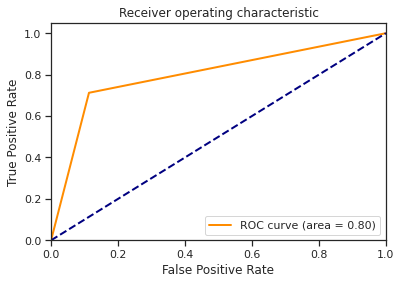

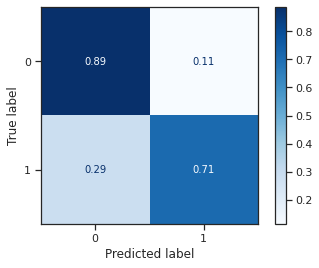

*****************************************************
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
*****************************************************
Метка 	 Accuracy
0 	 0.9339622641509434
1 	 0.6575342465753424
*****************************************************


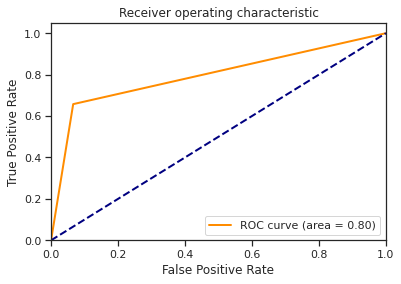

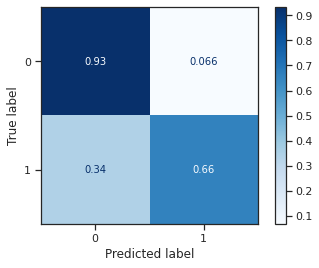

*****************************************************
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
*****************************************************
Метка 	 Accuracy
0 	 0.9150943396226415
1 	 0.6575342465753424
*****************************************************


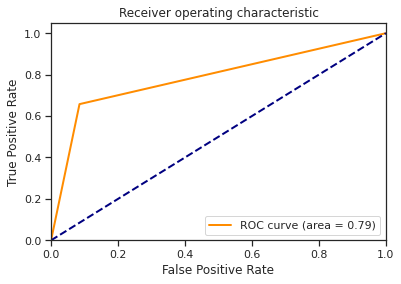

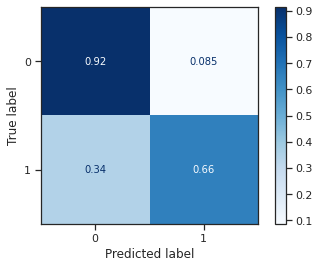

*****************************************************
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
*****************************************************
Метка 	 Accuracy
0 	 0.9056603773584906
1 	 0.6438356164383562
*****************************************************


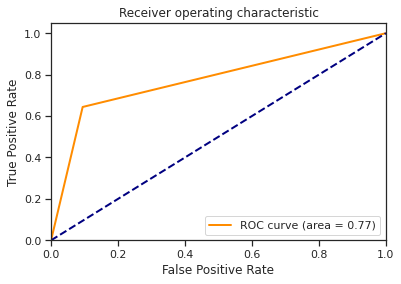

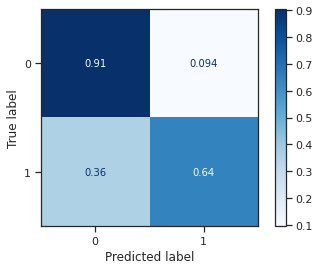

*****************************************************
BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)
*****************************************************
Метка 	 Accuracy
0 	 0.9433962264150944
1 	 0.6712328767123288
*****************************************************


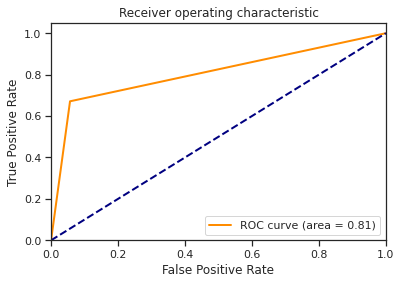

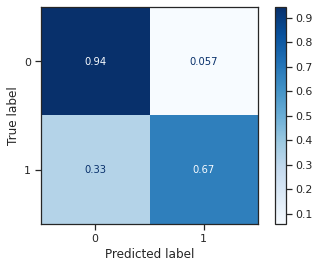

*****************************************************
ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
*****************************************************
Метка 	 Accuracy
0 	 0.9150943396226415
1 	 0.6575342465753424
*****************************************************


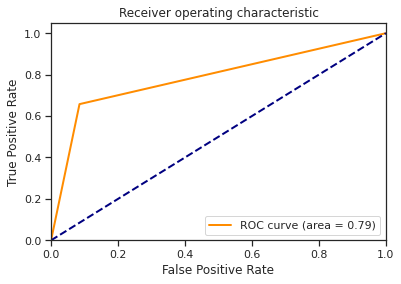

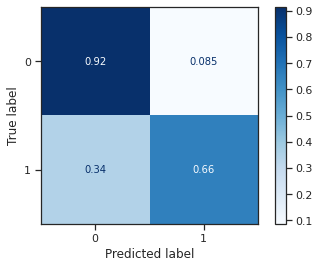

*****************************************************
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
*****************************************************
Метка 	 Accuracy
0 	 0.839622641509434
1 	 0.684931506849315
*****************************************************


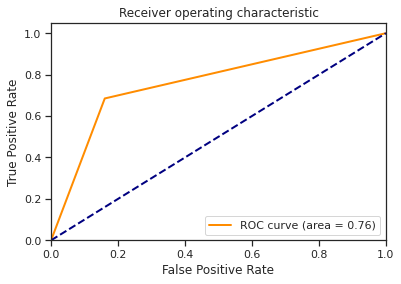

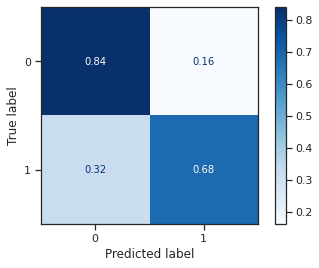

In [76]:
for model_name, model in clas_models.items():
    clas_train_model(model_name, model, clasMetricLogger)

Мы видим, что классификатор мешков имеет наилучшую производительность в зависимости от площади кривой ROC. Мы. также увидит меру других показателей по всем классификаторам, так что будет легче сравнивать.

In [77]:
clas_metrics = clasMetricLogger.df['metric'].unique()
clas_metrics

array(['precision', 'recall', 'f1', 'roc_auc'], dtype=object)

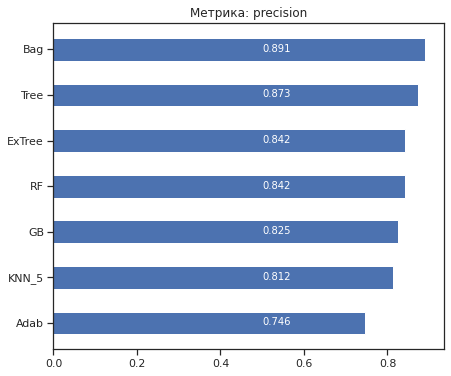

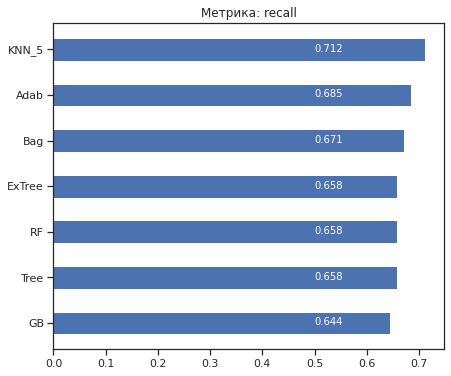

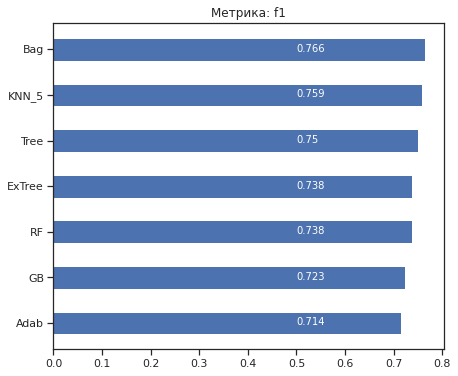

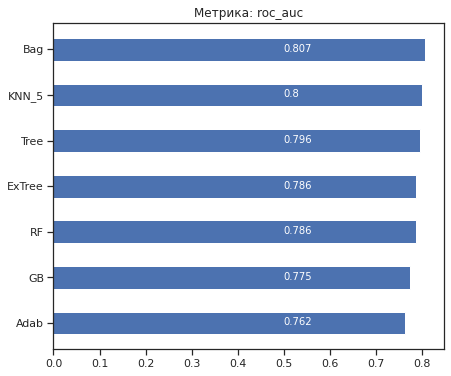

In [78]:
for metric in clas_metrics:
    clasMetricLogger.plot('Метрика: ' + metric, metric, figsize=(7, 6))

В соответствии с precision: дерево решений и классификаторы мешков имеют наилучшие значения.   
Согласно recall: классификатор адаптера и классификаторы k-соседей имеют лучшие значения.    
Согласно метрике «f1-Score»: наилучший результат имеют классификатор мешков и классификатор k-соседей.

#Подбор гиперпараметров для выбранных моделей.

Мы будем изменять количество соседей, которое имеет классификатор k-соседей. и увидеть лучшее значение, используя функцию поиска по сетке

In [115]:
param_grid = {
    'base_estimator__max_depth' : [1, 2, 3, 4, 5],
    'max_samples' : [0.05, 0.1, 0.2, 0.5],
    'base_estimator__max_leaf_nodes':[10, 15],
}
param_grid

{'base_estimator__max_depth': [1, 2, 3, 4, 5],
 'base_estimator__max_leaf_nodes': [10, 15],
 'max_samples': [0.05, 0.1, 0.2, 0.5]}

In [116]:
clf = GridSearchCV(BaggingClassifier(DecisionTreeClassifier(),
                                     n_estimators = 100, max_features = 0.5),
                   param_grid, scoring = 'recall')
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                               class_weight=None,
                                                                               criterion='gini',
                                                                               max_depth=None,
                                                                               max_features=None,
                                                                               max_leaf_nodes=None,
                                                                               min_impurity_decrease=0.0,
                                                                               min_impurity_split=None,
                                                                               min_samples_leaf=1,
                                                                      

In [117]:
clf.best_estimator_

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=1,
                                                        max_features=None,
                                                        max_leaf_nodes=10,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,
     

In [118]:
clf.best_params_

{'base_estimator__max_depth': 1,
 'base_estimator__max_leaf_nodes': 10,
 'max_samples': 0.5}

Таким образом, наилучшее число для классификатора k-соседей равно 13. Мы снова вычислим все метрики этого классификатора и посмотрим, будут ли они лучше, чем производительность классификатора мешков.

In [0]:
clas_models_grid = {'Bag_D5S0.5LN15':clf.best_estimator_}

*****************************************************
BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=1,
                                                        max_features=None,
                                                        max_leaf_nodes=10,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                          

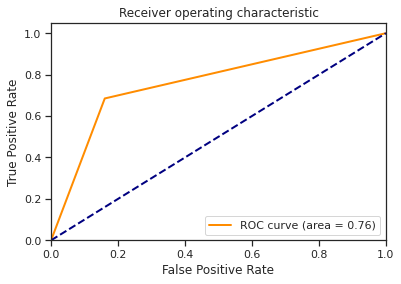

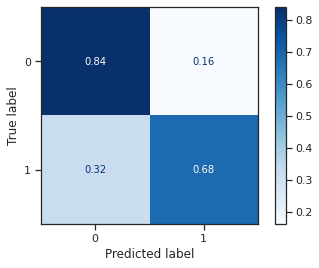

In [84]:
for model_name, model in clas_models_grid.items():
    clas_train_model(model_name, model, clasMetricLogger)

In [85]:
clf.best_estimator_.fit(X_train,y_train)
y_pred=clf.best_estimator_.predict(X_test)
recall = recall_score(y_test.values, y_pred)
recall

0.6712328767123288

In [86]:
X_train.shape

(712, 5)

In [87]:
n_range = np.array(range(1,500,4))
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([  1,   5,   9,  13,  17,  21,  25,  29,  33,  37,  41,  45,  49,
          53,  57,  61,  65,  69,  73,  77,  81,  85,  89,  93,  97, 101,
         105, 109, 113, 117, 121, 125, 129, 133, 137, 141, 145, 149, 153,
         157, 161, 165, 169, 173, 177, 181, 185, 189, 193, 197, 201, 205,
         209, 213, 217, 221, 225, 229, 233, 237, 241, 245, 249, 253, 257,
         261, 265, 269, 273, 277, 281, 285, 289, 293, 297, 301, 305, 309,
         313, 317, 321, 325, 329, 333, 337, 341, 345, 349, 353, 357, 361,
         365, 369, 373, 377, 381, 385, 389, 393, 397, 401, 405, 409, 413,
         417, 421, 425, 429, 433, 437, 441, 445, 449, 453, 457, 461, 465,
         469, 473, 477, 481, 485, 489, 493, 497])}]

In [88]:
clf_gs = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring='accuracy')
clf_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': array([  1,   5,   9,  13,  17,  21,  25,  29,  33,  37,  41,  45,  49,
        53,  57,  61,  65,  69,  73,  77,  81,  85,  89,  93,  97, 101,
       105, 109, 113, 117, 121, 125, 129, 1...
       209, 213, 217, 221, 225, 229, 233, 237, 241, 245, 249, 253, 257,
       261, 265, 269, 273, 277, 281, 285, 289, 293, 297, 301, 305, 309,
       313, 317, 321, 325, 329, 333, 337, 341, 345, 349, 353, 357, 361,
       365, 369, 373, 377, 381, 385, 389, 393, 397, 401, 405, 409, 413,
       417, 421, 425, 429, 433, 437, 441, 445, 449, 453

In [89]:
clf_gs.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=21, p=2,
                     weights='uniform')

In [90]:
clf_gs.best_params_

{'n_neighbors': 21}

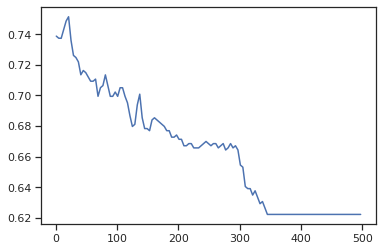

In [91]:
plt.plot(n_range, clf_gs.cv_results_['mean_test_score'])

In [0]:
clas_models_grid = {'KNN_21':clf_gs.best_estimator_}

*****************************************************
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=21, p=2,
                     weights='uniform')
*****************************************************
Метка 	 Accuracy
0 	 0.8490566037735849
1 	 0.5753424657534246
*****************************************************


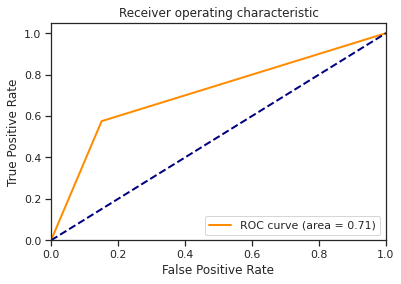

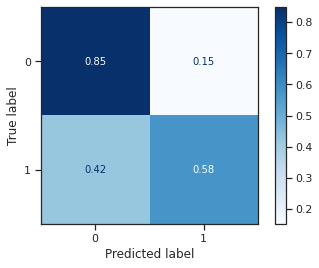

In [93]:
for model_name, model in clas_models_grid.items():
    clas_train_model(model_name, model, clasMetricLogger)

In [94]:
clf_gs.best_estimator_.fit(X_train,y_train)
y_pred=clf_gs.best_estimator_.predict(X_test)
precision = precision_score(y_test.values, y_pred)
precision

0.7241379310344828

Таким образом, производительность классификатора Bagging лучше, чем у классификатора 13-го соседа. Мы сделаем 10-кратное разделение поезда и данных испытаний. и увидеть среднее значение его точности исполнения.

In [95]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
clf = BaggingClassifier()
scoring = 'accuracy'
score = cross_val_score(clf, X_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)
round(np.mean(score)*100, 2)

[0.84722222 0.77777778 0.74647887 0.74647887 0.95774648 0.71830986
 0.70422535 0.83098592 0.84507042 0.83098592]


80.05

#Решение задачи классификации

Итак, наконец, мы используем классификатор Bagging и видим его производительность по сравнению с нашими тестовыми данными.

*****************************************************
BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)
*****************************************************
Метка 	 Accuracy
0 	 0.9433962264150944
1 	 0.6301369863013698
*****************************************************


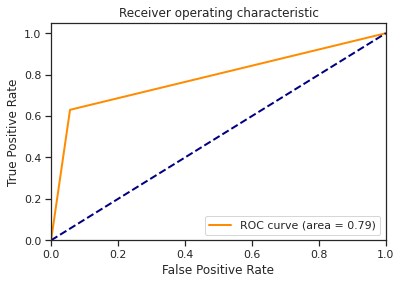

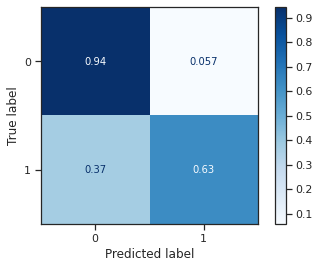

In [109]:
clas_models_grid = {'Bag':BaggingClassifier()}

for model_name, model in clas_models_grid.items():
    clas_train_model(model_name, model, clasMetricLogger)

#Выводы
Таким образом, в нашей модели мы хорошо изучили данные и решили, какой из ее столбцов подходит для построения модели (после обработки всего объекта и пропущенных данных из него). Затем мы использовали набор классификаторов и метрик для оценки их работы с нашими данными. Наилучшая производительность была у классификатора Bagging. Теперь мы можем использовать нашу модель для прогнозирования значений тестовых данных (данных без колонки выживания) и быть уверенными, что наша модель имеет точность приблизительно 80%.

In [119]:
preds=clf.best_estimator_.predict(test[['Pclass', 'Sex', 'Title','Fare', 'Cabin']])
my_submit = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': preds})
my_submit.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [0]:
my_submit.to_csv('/content/drive/My Drive/Titanic.csv', index=False)